In [ ]:
import sys, csv, json, subprocess, requests, pickle, torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from typing import List, Dict, Optional, Tuple
from tqdm import tqdm


sys.path.append("../..")
from config import colorspal6
from proteomelm.ppi.model import prepare_ppi

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14

env_dir = "/data2/malbrak/proteomelm/interactomes/human/"

## Preparation of the data

1. **Utility Functions**:  
    Several helper functions are defined for tasks such as average product correction, batch fetching of UniProt and UniParc sequences, and mapping STRING-DB protein IDs to UniProt IDs using BLAST.

2. **Extracting Unique Proteins and Fetching Sequences**:  
    Unique protein identifiers are extracted from DCA score files. Protein sequences are fetched from UniProt and UniParc, and saved in FASTA format for downstream analysis.

3. **Mapping STRING IDs to UniProt IDs**:  
    The notebook maps STRING-DB protein IDs to UniProt IDs using sequence alignment, ensuring consistent identifiers across datasets.

4. **Building Score Matrices**:  
    Protein sequences are loaded, and index mappings are created. DCA, RF, and AF score matrices are constructed for all protein pairs, ensuring symmetry and handling missing data.

5. **Preparing STRING Confidence Scores**:  
    STRING confidence scores are mapped to the protein pairs using the established UniProt mapping, and all score matrices are converted to upper-triangular vector form for efficient storage and analysis.

6. **Saving Processed Data**:  
    The processed score arrays are saved in `.npy` format for efficient loading in subsequent steps.

This preparation ensures that all protein pairs, sequence data, and interaction scores are harmonized and ready for feature extraction and model training.

In [3]:
def fetch_uniprot_sequences_batch(
    ids: List[str],
    batch_size: int = 100
) -> Dict[str, Tuple[str, int]]:
    """
    Fetches UniProtKB sequences in FASTA format given a list of accessions.

    Returns a dictionary mapping UniProt accession to (sequence, taxon ID).
    """
    url = "https://rest.uniprot.org/uniprotkb/stream"
    headers = {"Accept": "application/json"}
    sequences = {}
    ids = list(ids)

    for i in tqdm(range(0, len(ids), batch_size)):
        batch_ids = ids[i:i+batch_size]
        query = " OR ".join(f"accession:{pid}" for pid in batch_ids)
        params = {
            "query": query,
            "format": "json"
        }

        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            data = response.json()
            for entry in data.get("results", []):
                accession = entry.get("primaryAccession")
                sequence = entry.get("sequence", {}).get("value", "")
                if accession and sequence:
                    sequences[accession] = sequence
        else:
            print(f"Failed batch {i//batch_size + 1}: {response.status_code} – {response.text}")
    
    return sequences

def fetch_uniparc_sequences_batch(
    uniprot_ids: List[str],
    batch_size: int = 1
) -> Dict[str, str]:
    """
    Fetches UniParc sequences by UniProt accessions using the UniParc API.

    Returns a dict mapping UniProt accessions to sequences.
    """
    base_url = "https://rest.uniprot.org/uniparc/search"
    headers = {"Accept": "application/json"}
    session = requests.Session()
    sequences: Dict[str, str] = {}

    for i in tqdm(range(0, len(uniprot_ids), batch_size), desc="Fetching UniParc sequences"):
        batch = uniprot_ids[i:i + batch_size]
        query = " OR ".join(batch)
        params = {"query": query, "format": "json", "size": 500}

        response = session.get(base_url, headers=headers, params=params)
        if response.status_code != 200:
            print(f"[ERROR] Failed to fetch batch {i // batch_size + 1}: {response.status_code}")
            continue

        for entry in response.json().get("results", []):
            accessions = entry.get("uniProtKBAccessions", [])
            sequence = entry.get("sequence", {}).get("value", "")
            if not accessions or not sequence:
                continue
            cleaned_accessions = [acc.split(".")[0] for acc in accessions]
            for acc in cleaned_accessions:
                if acc in batch:
                    sequences[acc] = sequence

    return sequences

def map_string_to_uniprot(
    fasta_uniprot: str,
    fasta_string: str,
    db_name: str = "uniprot_db",
    blast_output: str = "string_vs_uniprot.tsv",
    identity_thresh: float = 95.0,
    cov_thresh: float = 90.0,
    threads: int = 4,
    json_output: Optional[str] = None
) -> Dict[str, str]:
    """
    Maps STRING protein IDs to UniProt accessions using BLASTP alignment.

    Parameters:
    - fasta_uniprot: Path to UniProt FASTA file (target).
    - fasta_string: Path to STRING FASTA file (query).
    - db_name: Output prefix for BLAST DB.
    - blast_output: Output file for BLAST tabular results.
    - identity_thresh: Minimum % identity to retain hit.
    - cov_thresh: Minimum % query coverage to retain hit.
    - threads: Number of threads to use.
    - json_output: Optional path to save resulting mapping as JSON.

    Returns:
    - Dictionary mapping STRING IDs to UniProt IDs.
    """
    # 1. Create BLAST database
    subprocess.run([
        "makeblastdb", "-in", fasta_uniprot, "-dbtype", "prot", "-out", db_name
    ], check=True)

    # 2. Run BLASTP
    subprocess.run([
        "blastp",
        "-query", fasta_string,
        "-db", db_name,
        "-outfmt", "6 qseqid sseqid pident qcovs evalue bitscore",
        "-qcov_hsp_perc", str(cov_thresh),
        "-num_threads", str(threads),
        "-out", blast_output
    ], check=True)

    # 3. Parse BLAST output
    best_hits: Dict[str, Dict[str, float]] = {}
    with open(blast_output) as f:
        reader = csv.DictReader(f, fieldnames=[
            "qseqid", "sseqid", "pident", "qcovs", "evalue", "bitscore"
        ], delimiter="\t")
        for row in reader:
            pident = float(row["pident"])
            qcov = float(row["qcovs"])
            bitscore = float(row["bitscore"])
            if pident < identity_thresh or qcov < cov_thresh:
                continue
            qid = row["qseqid"]
            if qid not in best_hits or bitscore > best_hits[qid]["bitscore"]:
                best_hits[qid] = {
                    "uniprot_id": row["sseqid"],
                    "bitscore": bitscore
                }

    mapping = {q: hit["uniprot_id"] for q, hit in best_hits.items()}

    if json_output:
        with open(json_output, "w") as f:
            json.dump(mapping, f, indent=2)

    return mapping

In [13]:
unique_proteins = set()
with open(env_dir + "DCA_scores_baker.txt", "r") as f:
    for line in tqdm(f, desc="Reading DCA scores"):
        parts = line.strip().split("\t")
        try:
            protein1, protein2 = parts[0].split("_")
        except:
            print(f"Skipping malformed line: {line.strip()}")
            continue
        if len(parts) < 2:
            continue
        unique_proteins.add(protein1)
        unique_proteins.add(protein2)

Reading DCA scores: 188936347it [02:34, 1219741.16it/s]


In [14]:
sequences = fetch_uniprot_sequences_batch(unique_proteins, batch_size=1000)
missing_proteins = [pid for pid in unique_proteins if pid not in sequences]
print(f"Missing proteins: {len(missing_proteins)}")
if missing_proteins:
    sequences_uniparc = fetch_uniparc_sequences_batch(list(missing_proteins), batch_size=100)
    sequences.update(sequences_uniparc)

with open(f"{env_dir}/uniprot_sequences.fasta", "wb") as f:
    for k, v in sequences.items():
        f.write(f">{k}\n{v}\n".encode())

100%|██████████| 20/20 [01:26<00:00,  4.30s/it]


Missing proteins: 109


Fetching UniParc sequences: 100%|██████████| 2/2 [00:14<00:00,  7.07s/it]


In [ ]:
fasta_file = f"{env_dir}/uniprot_sequences.fasta"
string_fasta = f"{env_dir}/9606.protein.sequences.v12.0.fa"
mapping = map_string_to_uniprot(
    fasta_uniprot=fasta_file,
    fasta_string=string_fasta,
    db_name=f"{env_dir}/uniprot_db",
    blast_output=f"{env_dir}/string_vs_uniprot.tsv",
    identity_thresh=95.0,
    cov_thresh=90.0,
    threads=4,
    json_output=f"{env_dir}/mapping.json"
)

In [15]:
sequences = {}
with open(env_dir + "uniprot_sequences.fasta", "r") as f:
    current_id = None
    seq_lines = []
    for line in f:
        if line.startswith(">"):
            if current_id and seq_lines:
                sequences[current_id] = "".join(seq_lines)
            current_id = line.strip()[1:]  # Remove '>'
            seq_lines = []
        else:
            seq_lines.append(line.strip())
    if current_id and seq_lines:
        sequences[current_id] = "".join(seq_lines)    
            
protein_lists = list(sequences.keys())
protein_indexes = {pid: i for i, pid in enumerate(protein_lists)}
dca_scores = -np.ones((len(protein_lists), len(protein_lists)), dtype=np.float16)
with open(env_dir + "DCA_scores_baker.txt", "r") as f:
    for line in tqdm(f, desc="Processing DCA scores"):
        parts = line.strip().split("\t")
        if len(parts) < 2:
            continue
        if len(parts[0].split("_")) != 2:
            print(f"Skipping malformed line: {line.strip()}")
            continue
        protein1, protein2 = parts[0].split("_")
        try:
            score = float(parts[1])
        except ValueError:
            print(f"Skipping line with non-numeric score: {line.strip()}")
            continue
        if protein1 in protein_indexes and protein2 in protein_indexes:
            i = protein_indexes[protein1]
            j = protein_indexes[protein2]
            dca_scores[i, j] = score
            dca_scores[j, i] = score  # Assuming symmetric scores

rf_scores = -np.ones((len(protein_lists), len(protein_lists)), dtype=np.float16)
with open(env_dir + "RF_scores_baker.txt", "r") as f:
    for line in tqdm(f, desc="Processing RF scores"):
        parts = line.strip().split("\t")
        if len(parts) < 2:
            continue
        protein1, protein2 = parts[0].split("_")
        score = float(parts[1])
        if protein1 in protein_indexes and protein2 in protein_indexes:
            i = protein_indexes[protein1]
            j = protein_indexes[protein2]
            rf_scores[i, j] = score
            rf_scores[j, i] = score  # Assuming symmetric scores
            
af_scores = -np.ones((len(protein_lists), len(protein_lists)), dtype=np.float16)
with open(env_dir + "AF_scores_baker.txt", "r") as f:
    for line in tqdm(f, desc="Processing AF scores"):
        parts = line.strip().split("\t")
        if len(parts) < 2:
            continue
        protein1, protein2 = parts[0].split("_")
        score = float(parts[1])
        if protein1 in protein_indexes and protein2 in protein_indexes:
            i = protein_indexes[protein1]
            j = protein_indexes[protein2]
            af_scores[i, j] = score
            af_scores[j, i] = score  # Assuming symmetric scores

Processing DCA scores: 188936347it [05:56, 530498.42it/s]
Processing RF scores: 46979065it [01:16, 611346.62it/s]
Processing AF scores: 3189749it [00:05, 603353.81it/s]


In [16]:
labels = []
organism = "9606"  # Human
fasta_file = f"{env_dir}/uniprot_sequences.fasta"
with open(fasta_file) as f:
    for line in f:
        if line.startswith(">"):
            labels.append(line[1:].strip())
labels_to_i = {label: i for i, label in enumerate(labels)}
mapping = json.load(open(f"{env_dir}/mapping.json", "r"))
links = pd.read_table(f"{env_dir}/{organism}.protein.links.detailed.v12.0.txt", sep=" ")
links["protein1"] = links["protein1"].map(lambda x: mapping.get(x, None))
links["protein2"] = links["protein2"].map(lambda x: mapping.get(x, None))
y_scores = np.zeros((len(labels), len(labels)), dtype=np.float32)
for i, row in links.iterrows():
    if row["protein1"] in labels_to_i and row["protein2"] in labels_to_i:
        y_scores[labels_to_i[row["protein1"]], labels_to_i[row["protein2"]]] = row["combined_score"]
        y_scores[labels_to_i[row["protein2"]], labels_to_i[row["protein1"]]] = row["combined_score"]
y_scores = y_scores[np.triu_indices(len(labels), k=1)]
dca_scores = dca_scores[np.triu_indices(len(labels), k=1)]
rf_scores = rf_scores[np.triu_indices(len(labels), k=1)]
af_scores = af_scores[np.triu_indices(len(labels), k=1)]

In [17]:
# numpy saves the arrays in a more efficient format
np.save(f"{env_dir}/string_scores.npy", y_scores)
np.save(f"{env_dir}/dca_scores_baker.npy", dca_scores)
np.save(f"{env_dir}/rf_scores_baker.npy", rf_scores)
np.save(f"{env_dir}/af_scores_baker.npy", af_scores)

## Perform PPI prediction

In this section, we perform protein-protein interaction (PPI) prediction using deep learning-based representations and traditional methods. The workflow proceeds as follows:

1. **Feature Extraction**: We use the `prepare_ppi` function to generate representations and attention maps for protein pairs from the pre-trained ProteomeLM model (see cell 10).

2. **Data Preparation**: The extracted features, along with DCA, RF, and AF scores, are loaded and split into training and validation sets (cells 11–12).

3. **Model Training**: A logistic regression model is trained on the extracted features to distinguish interacting from non-interacting protein pairs (cell 14).

4. **Evaluation and Saving Results**: The trained model's predictions are evaluated and saved, along with the model itself, for downstream analysis (cell 15).

This stepwise approach enables robust benchmarking of deep learning-based PPI prediction against established methods.

In [4]:
env_dir = f"/data2/malbrank/proteomelm/interactomes/human/"
checkpoint = "/data2/common/proteomelm/ProteomeLM-S/checkpoint-210"

batch_size = 256

esm_device = "cuda:0"
proteomelm_device = "cpu"
include_attention = True
reload_if_possible = True
include_all_hidden_states = False

encoded_genome_file = f"{env_dir}/dump_dict_esm_uniprot_sequences.pt"
fasta_file = f"uniprot_sequences.fasta"

In [5]:
output = prepare_ppi(
        checkpoint,
        env_dir + fasta_file,
        encoded_genome_file=encoded_genome_file,
        keep_heads=None,
        esm_device=esm_device,
        proteomelm_device=proteomelm_device,
        use_odb=False,
        include_attention=include_attention,
        include_all_hidden_states=include_all_hidden_states,
        reload_if_possible=reload_if_possible
)
attention = torch.cat([x[0] for x in output["plm_attentions"]], 0).permute(1, 2, 0) # dim:[n_layers, n_heads, n_tokens, n_tokens]
A = attention[np.triu_indices(attention.shape[0], k=1)] # dim:[n_tokens, n_tokens, n_layers * n_heads]

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [5]:
dca_scores = np.load(f"{env_dir}/dca_scores_baker.npy")
rf_scores = np.load(f"{env_dir}/rf_scores_baker.npy")
af_scores = np.load(f"{env_dir}/af_scores_baker.npy")
y_scores = np.load(f"{env_dir}/string_scores.npy")

In [32]:
np.random.seed(42)
positive_idx = np.where(y_scores >= 990)[0]
negative_idx = np.where(y_scores < 990)[0]
positive_randperm = positive_idx[np.random.permutation(len(positive_idx))] 
negative_randperm = negative_idx[np.random.permutation(len(negative_idx))]
idx_train = np.concatenate([positive_randperm[:100], negative_randperm[:1000]])
idx_val = np.concatenate([positive_randperm[100:], negative_randperm[1000:]])

X_train = A[idx_train]
y_train = y_scores[idx_train] >= 990
X_val = A[idx_val]
y_val = (y_scores[idx_val] >= 990)
y_scores = y_scores[idx_val]
dca_scores = dca_scores[idx_val]
rf_scores = rf_scores[idx_val]
af_scores = af_scores[idx_val]
X_train = X_train.float()
X_val = X_val.float()

In [33]:
model = LogisticRegression(class_weight="balanced", max_iter = 10000)
model.fit(X_train, y_train)
proteomelm_scores = model.predict_proba(X_val)[:, 1]

In [38]:
suffix_name = "proteomelm-s"

with open(f"{env_dir}/result_{suffix_name}.pkl", "wb") as f:
    pickle.dump({
        "dca_scores": dca_scores,
        "rf_scores": rf_scores,
        "af_scores": af_scores,
        "string_scores": y_scores,
        "proteomelm_scores": proteomelm_scores
    }, f)

# save the logistic regression model
with open(f"{env_dir}/logistic_regression_model_human.pkl", "wb") as f:
    pickle.dump((model, model.coef_, model.intercept_), f)

## Output

In this section, we analyze and visualize the results of PPI prediction. We compare the performance of ProteomeLM-based predictions with traditional DCA and RF methods, evaluate prediction accuracy at various STRING confidence thresholds, and assess computational efficiency. The following steps are included:

1. **Load Results**: Load prediction scores and ground truth labels for the validation set.
2. **Threshold Analysis**: Assess the fraction of top predictions exceeding STRING confidence thresholds.
3. **ROC Curve Evaluation**: Plot ROC curves to compare recall and AUROC across methods.
4. **Compute Cost Comparison**: Visualize the computational cost (FLOPs) for DCA and ProteomeLM approaches.

These analyses provide a comprehensive evaluation of model performance and computational trade-offs.

In [2]:
env_dir = "/data2/malbrank/proteomelm/interactomes/human/"
suffix_name = "proteomelm-s"
with open(f"{env_dir}/result_{suffix_name}.pkl", "rb") as f:
    results = pickle.load(f)

dca_scores = results["dca_scores"]

rf_scores = results["rf_scores"]
af_scores = results["af_scores"]
string_scores = results["string_scores"]
proteomelm_scores = results["proteomelm_scores"]

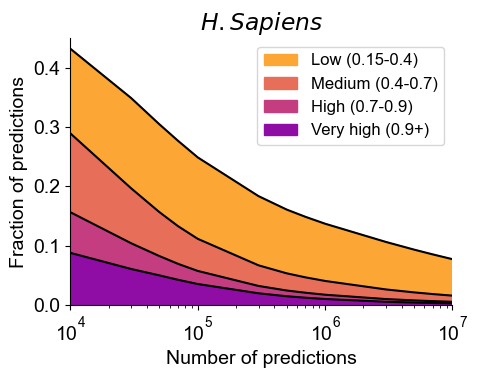

In [18]:
Ns = [10000, 30000, 50000, 70000, 100000, 300000, 500000, 700000, 1000000, 3000000, 5000000, 7000000, 10000000, 30000000, 50000000, 70000000, 100000000]
thrs = [150, 400, 700, 900]

thrs_labels = ["Low (0.15-0.4)", "Medium (0.4-0.7)", "High (0.7-0.9)", "Very high (0.9+)"]
indices = np.argsort(proteomelm_scores)[::-1]
y_sorted_by_proteomelm_score = string_scores[indices]
X = np.zeros((len(Ns), len(thrs)))
for i, n in enumerate(Ns):
    for j, thr in enumerate(thrs):
        X[i, j] = np.sum(y_sorted_by_proteomelm_score[:n] >= thr)/n

# plasma colormap with 4 thresholds
cmap = plt.get_cmap('plasma')
colors = [cmap(i) for i in np.linspace(0.3, 0.8, 4)][::-1]
plt.figure(figsize=(5, 4))
for i, thr in enumerate(thrs):
    plt.plot(Ns, X[:, i], color="black", linestyle="-")
    plt.fill_between(Ns, X[:, i], alpha=1, color=colors[i], label=thrs_labels[i])

plt.title(f"$\\mathbf{{\\it{{H. Sapiens}}}}$", fontweight="bold")
plt.xscale("log")
plt.xlim(10000, 10000000)
plt.xlabel("Number of predictions")

plt.ylim(0, 0.45)
plt.ylabel("Fraction of predictions")

plt.legend(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f"{env_dir}/fraction_above_threshold_human_{suffix_name}.svg", dpi=300)
plt.show()

Number of positive examples: 20933 out of 190621475 (0.01%)


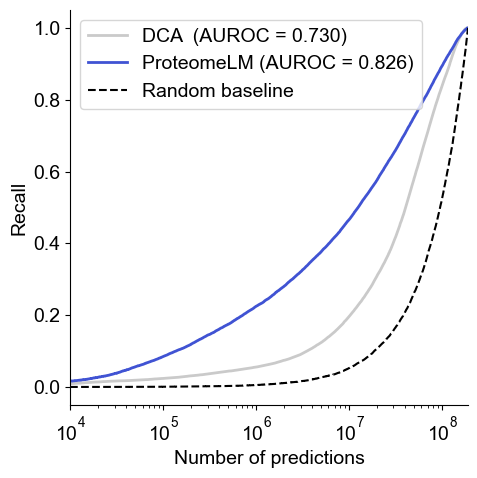

In [19]:
y = string_scores > 990
N = len(y)
P = np.sum(y)
print(f"Number of positive examples: {P} out of {N} ({P/N:.2%})")

plt.figure(figsize=(5, 5))
fpr, tpr, _ = roc_curve(y, dca_scores)
roc_auc = auc(fpr, tpr)
plt.plot([(N-P)*x + P*y for x, y in zip(fpr, tpr)], tpr, label=f"DCA  (AUROC = {roc_auc:0.3f})", color=colorspal6[-1], linewidth=2)

fpr, tpr, _ = roc_curve(y, proteomelm_scores)
roc_auc = auc(fpr, tpr)
plt.plot([(N-P)*x+P*y for x, y in zip(fpr, tpr)], tpr, label=f"ProteomeLM (AUROC = {roc_auc:0.3f})", color=colorspal6[0], linewidth=2)

# random baseline
fpr, tpr, _ = roc_curve(y, np.random.rand(len(y)))
plt.plot([(N-P)*x+P*y for x, y in zip(fpr, tpr)], tpr, label="Random baseline", linestyle="--", color="black")

plt.xscale("log")
plt.xlim(10000, N)
#plt.ylim(0, 1)
plt.xlabel("Number of predictions")
plt.ylabel("Recall")
plt.legend(loc="upper left")
#plt.title("ROC curve on  $\\it{{H. Sapiens}}$ interactome", fontweight="bold")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f"{env_dir}/roc_plm_vs_dca_human_{suffix_name}.svg", dpi=300)

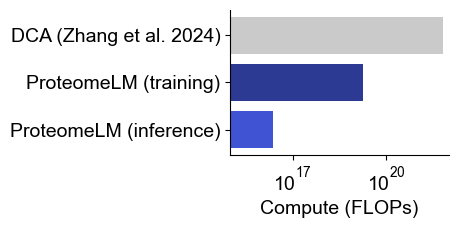

In [20]:

# Define the compute in FLOPs for the three tasks
compute_flops = {
    "DCA (Zhang et al. 2024)": 6.5e21,  # Midpoint estimate
    "ProteomeLM (training)": 1.74e19,  # H100 72h
    "ProteomeLM (inference)": 2.32e16,  # A6000 10 minutes
}

# Prepare data for plotting
labels = list(compute_flops.keys())[::-1]  # Reverse order for horizontal bar plot
flops = list(compute_flops.values())[::-1]

# Plotting
plt.figure(figsize=(5, 2.5))
plt.barh(labels, flops, log=True, color=[colorspal6[0], [0.7*x for x in colorspal6[0]], colorspal6[-1]])
plt.xlabel("Compute (FLOPs)")
plt.xlim(1e15, 1e22)
#plt.title("Cost Comparison", fontweight="bold")
plt.yticks()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.grid(True, which="both", axis="x", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(f"{env_dir}/compute_cost_comparison_human_{suffix_name}.svg", dpi=300)
plt.show()